<b style="font-family: Verdana" id="imports">Appendix</b><p>
student email: 220426@softwarica.edu.np

<p id="toc"></p>


# <b style="font-family: Verdana" id="imports">TABLE OF CONTENTS</b>

<a id="toc"></a>

- [1 | Setup](#1)
- [2 | Exploring the dataset](#2)
- [3 | Data Preprocessing](#3)
    - [3.1 | Image Data Augmentation](#3.1)
    - [3.2 | Label encoder-decoder](#3.2)
    - [3.3 | Train-Val Split](#3.3)
    - [3.4 | Data Generators](#3.4)
- [4 | Model](#4)    
    - [4.1 | Build](#4.1)
    - [4.2 | Compile](#4.2)
    - [4.3 | Train](#4.3)
    - [4.4 | Evaluate](#4.4)
- [5 | Testing](#5)

<a id="1"></a>
# <b style="font-family: Verdana">1 <span style='color:#43B0C1'>|</span> SETUP</b>

In [2]:
# Miscellaneous
from tqdm import tqdm
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output
clear_output()

<a id="2"></a>
# <b style="font-family: Verdana">2 <span style='color:#43B0C1'>|</span> EXPLORING THE DATASET</b>

This is the dataset structure
```bash
├── chest-xray-pneumoniacovid19tuberculosis
│   ├── test
│   │   ├── COVID19
│   │   │   └── ...
│   │   ├── NORMAL
│   │   │   ├── ...
│   │   ├── PNEUMONIA
│   │   │   └── ...
│   │   ├── TURBERCULOSIS
│   │   │   └── ...
│   ├── train
│   │   ├── COVID19
│   │   │   └── ...
│   │   ├── NORMAL
│   │   │   └── ...
│   │   ├── PNEUMONIA
│   │   │   └── ...
│   │   ├── TURBERCULOSIS
│   │   │   └── ...
│   ├── val
│   │   ├── COVID19
│   │   │   └── ...
│   │   ├── NORMAL
│   │   │   └── ...
│   │   ├── PNEUMONIA
│   │   │   └── ...
│   │   └── TURBERCULOSIS
            └── ...
```


In [3]:
data_directories = ['/content/drive/MyDrive/kaggle/test/',
                    '/content/drive/MyDrive/kaggle/train/',
                    '/content/drive/MyDrive/kaggle/val/']

all_paths = []
all_labels = []

for data_dir in data_directories:
    for label in os.listdir(data_dir):
        for image in os.listdir(data_dir+label):
            all_paths.append(data_dir+label+'/'+image)
            if label=='TURBERCULOSIS':
                all_labels.append('TUBERCULOSIS')
            else:
                all_labels.append(label)

all_paths, all_labels = shuffle(all_paths, all_labels)

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path':all_paths, 'label':all_labels})
df

,path,label
0,/content/drive/MyDrive/kaggle/train/PNEUMONIA/person602_bacteria_2460.jpeg,PNEUMONIA
1,/content/drive/MyDrive/kaggle/train/COVID19/COVID19(344).jpg,COVID19
2,/content/drive/MyDrive/kaggle/train/PNEUMONIA/person1107_virus_1831.jpeg,PNEUMONIA
3,/content/drive/MyDrive/kaggle/train/NORMAL/NORMAL2-IM-0449-0001.jpeg,NORMAL
4,/content/drive/MyDrive/kaggle/train/NORMAL/NORMAL2-IM-1116-0001.jpeg,NORMAL
...,...,...
7130,/content/drive/MyDrive/kaggle/train/PNEUMONIA/person339_bacteria_1573.jpeg,PNEUMONIA
7131,/content/drive/MyDrive/kaggle/train/PNEUMONIA/person1353_virus_2333.jpeg,PNEUMONIA
7132,/content/drive/MyDrive/kaggle/test/NORMAL/NORMAL2-IM-0110-0001.jpeg,NORMAL
7133,/content/drive/MyDrive/kaggle/train/PNEUMONIA/person298_bacteria_1413.jpeg,PNEUMONIA


In [4]:
df.groupby('label').count()

,path
label,
COVID19,576
NORMAL,1583
PNEUMONIA,4273
TUBERCULOSIS,703


In [5]:
#Configuration
IMAGE_SIZE = 128
  # Data Augmentation
BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
CONTRAST   = (0.64, 1.37) # (MIN, MAX)

# Train-Val Split
TRAIN_VAL_SPLIT = 0.8 # 80% of all the samples are used for training, and the rest for validation

# Model Training
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 0.00008

<a id="3"></a>
# <b style="font-family: Verdana">3 <span style='color:#43B0C1'>|</span> DATA PREPROCESSING</b>

<a id="3.1"></a>
<h2 style="font-family: Verdana">3.1 <span style='color:#43B0C1; font-weight: bold;'>|</span> Image Data Augmentation</h2>  

Image Augmentation is a process that is used to create new images for training by slightly altering the pixel values.  
We have a small dataset, so we can apply some image augmentation techniques to prevent overfitting of the model.

In [6]:
def augment_image(image):
    # Convert input image from numpy to PIL Image
    image = Image.fromarray(np.uint8(image))
    # Select brightness and contrast factors
    brightness_factor = random.uniform(BRIGHTNESS[0],BRIGHTNESS[1])
    contrast_factor = random.uniform(CONTRAST[0],CONTRAST[1])
    # Apply Transformations
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    return image

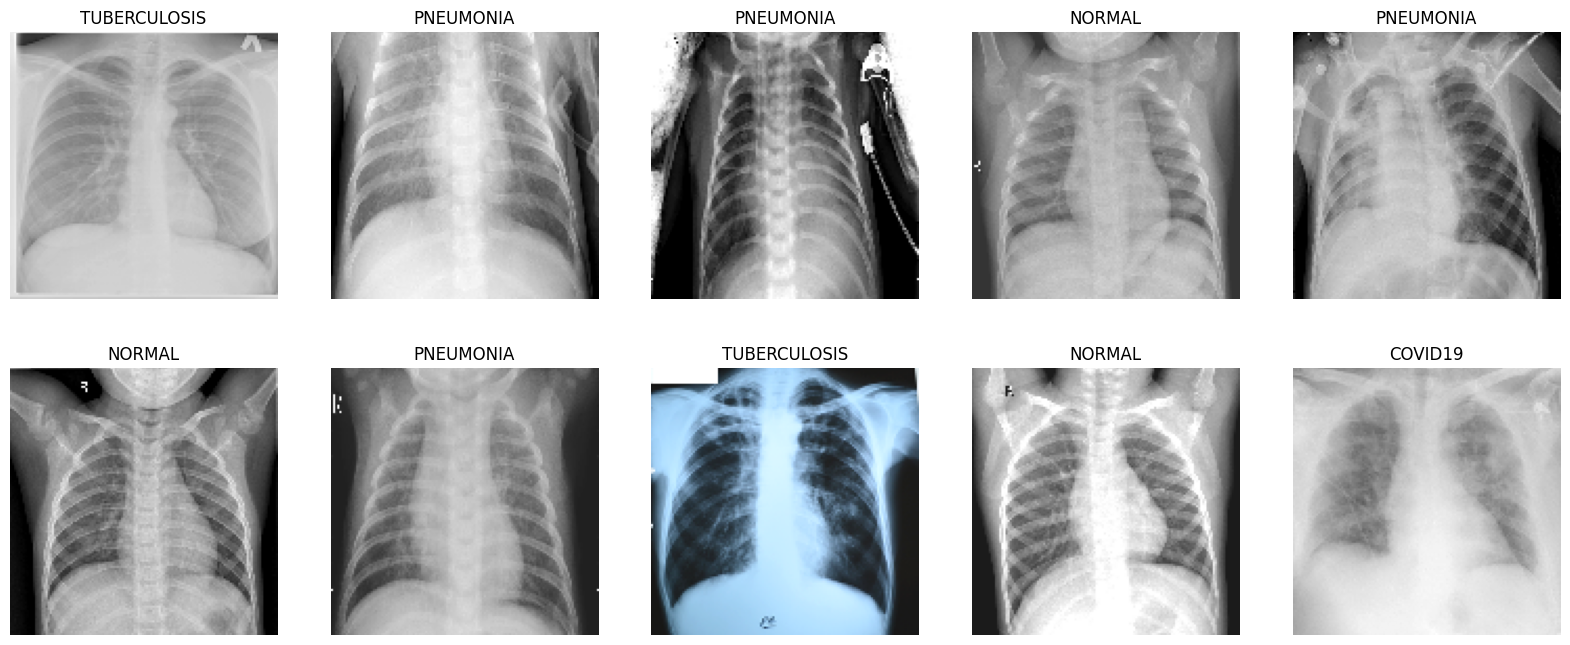

In [7]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(df.path[k:k+10])
labels = list(df.label[k:k+10])
images = open_images(image_paths, augment=True)

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

<a id="3.2"></a>
<h2 style="font-family: Verdana">3.2 <span style='color:#43B0C1; font-weight: bold;'>|</span> Label encoder-decoder</h2>  

Creating a dictionary `label_encoder` to convert string label to interger-encoded label  
And another dictionary `label_decoder` to decode the integer-encoded label

In [8]:
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID19'}

<a id="3.3"></a>
<h2 style="font-family: Verdana">3.3 <span style='color:#43B0C1; font-weight: bold;'>|</span> Train-Val Split</h2>  

Here dataset is splitted, 80% for training & 20% for validation  
we can change the percentage of samples for training and validation.
Training a model on this <b><mark>highly imbalanced</mark></b> dataset will cause the model to <b><mark>overfit</mark></b> on the class that is in excess and fail to learn patterns from other classes.

In [9]:
df_train = df[:int(TRAIN_VAL_SPLIT*len(df))]
df_val = df[int(TRAIN_VAL_SPLIT*len(df)):]

<a id="3.4"></a>
<h2 style="font-family: Verdana">3.4 <span style='color:#43B0C1; font-weight: bold;'>|</span> Data Generators</h2>  

`data_generator` is the generator function which we will use for training. It has 4 input parameters:
- `df`: This is the dataframe containing the image paths and labels
- `batch_size` (int): Batch size of training samples
- `augment` (boolean): If true, the augmentation techniques defined before will be applied to the images. We will set this to `True` during training and `False` during validation
- `epochs` (int): Number of epochs

In [10]:
def data_generator(df, batch_size=BATCH_SIZE, augment=True, epochs=EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [11]:
# Creating generators for training and validation. You can change the parameters in the configuration section.
train_data_generator = data_generator(df_train, batch_size=BATCH_SIZE, augment=True, epochs=EPOCHS)
train_steps = int(len(df_train)/BATCH_SIZE)

val_data_generator = data_generator(df_val, batch_size=BATCH_SIZE, augment=False, epochs=EPOCHS)
val_steps = int(len(df_val)/BATCH_SIZE)

<a id="4"></a>
# <b style="font-family: Verdana">4 <span style='color:#43B0C1'>|</span> MODEL</b>

<a id="4.1"></a>
<h2 style="font-family: Verdana">4.1 <span style='color:#43B0C1; font-weight: bold;'>|</span> Build</h2>

In [12]:
model = models.Sequential()
model.add(layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same' ))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same' ))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dropout(0.5, name='dropout1'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                   

<a id="4.2"></a>
<h2 style="font-family: Verdana">4.2 <span style='color:#43B0C1; font-weight: bold;'>|</span> Compile</h2>  

`sparse_categorical_crossentropy` and `categorical_crossentropy` are basically the same loss functions, just their input formats are different.  
the labels from the data generators are <b><mark>integer-encoded</mark></b>, so we are using `sparse_categorical_crossentropy`  

In [13]:
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

<a id="4.3"></a>
<h2 style="font-family: Verdana">4.3 <span style='color:#43B0C1; font-weight: bold;'>|</span> Train</h2>  

For training, we're using the data generators previously defined and we can change the parameters of training in the configuration section.  
I'm training for 13 epochs with a batch size of 8, and using a callback function to save only the model with the highest 'val_accuracy'

In [14]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history = model.fit(train_data_generator, epochs=EPOCHS, steps_per_epoch=train_steps,
          validation_data=val_data_generator, validation_steps=val_steps, callbacks=[model_checkpoint_callback])

Epoch 1/10
713/713 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.8310
Epoch 1: val_accuracy improved from -inf to 0.90590, saving model to model.hdf5
713/713 [==============================] - 1722s 2s/step - loss: 0.4508 - accuracy: 0.8310 - val_loss: 0.2564 - val_accuracy: 0.9059
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


713/713 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9153
Epoch 2: val_accuracy improved from 0.90590 to 0.92697, saving model to model.hdf5
713/713 [==============================] - 106s 148ms/step - loss: 0.2306 - accuracy: 0.9153 - val_loss: 0.2172 - val_accuracy: 0.9270
Epoch 3/10
713/713 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9319
Epoch 3: val_accuracy improved from 0.92697 to 0.93118, saving model to model.hdf5
713/713 [==============================] - 105s 147ms/step - loss: 0.1845 - accuracy: 0.9319 - val_loss: 0.1775 - val_accuracy: 0.9312
Epoch 4/10
713/713 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9502
Epoch 4: val_accuracy improved from 0.93118 to 0.93399, saving model to model.hdf5
713/713 [==============================] - 104s 147ms/step - loss: 0.1565 - accuracy: 0.9502 - val_loss: 0.1813 - val_accuracy: 0.9340
Epoch 5/10
713/713 [==============================] - ETA: 0s - loss:

<a id="4.4"></a>
<h2 style="font-family: Verdana">4.4 <span style='color:#43B0C1; font-weight: bold;'>|</span> Evaluate</h2>  :

In [15]:
val_data_generator = data_generator(df_val, batch_size=BATCH_SIZE, augment=False, epochs=1)
val_steps = int(len(df_val)/BATCH_SIZE)

y_pred = []
y_true = []

for x,y in tqdm(val_data_generator, total=val_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(label_decoder[i])
    for i in y:
        y_true.append(label_decoder[i])
clear_output()
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

     COVID19     0.9730    0.8504    0.9076       127
      NORMAL     0.8997    0.9055    0.9026       307
   PNEUMONIA     0.9656    0.9576    0.9616       850
TUBERCULOSIS     0.8659    0.9930    0.9251       143

    accuracy                         0.9404      1427
   macro avg     0.9260    0.9266    0.9242      1427
weighted avg     0.9421    0.9404    0.9404      1427



In [16]:
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[108,   4,   1,  14],
       [  0, 278,  27,   2],
       [  3,  27, 814,   6],
       [  0,   0,   1, 142]])

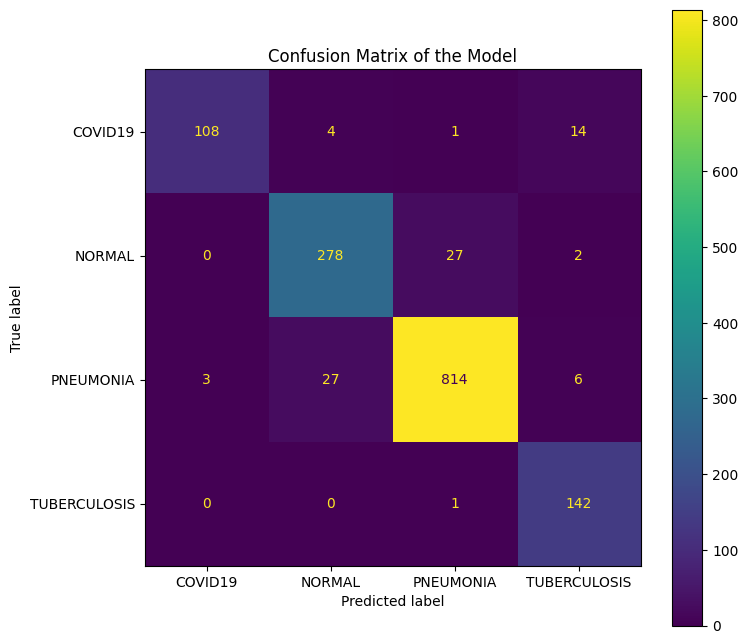

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
class_names = ['COVID19','NORMAL','PNEUMONIA','TUBERCULOSIS']

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,8), dpi=100)

# initialize using the raw 2D confusion matrix
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(cnf_matrix, display_labels=class_names)

# set the plot title using the axes object
ax.set(title='Confusion Matrix of the Model')

# show the plot.
display.plot(ax=ax);

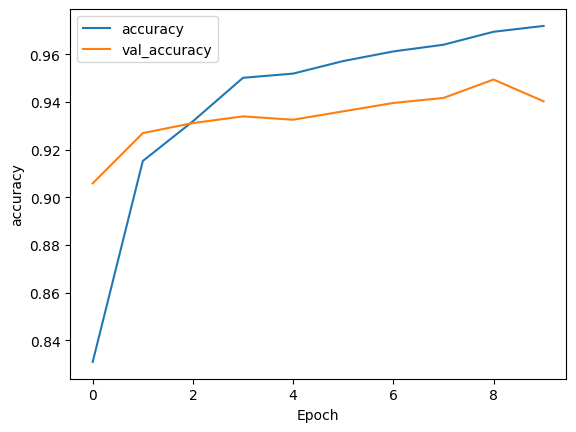

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
# plt.ylim([0.86,1])
plt.legend()
plt.show()

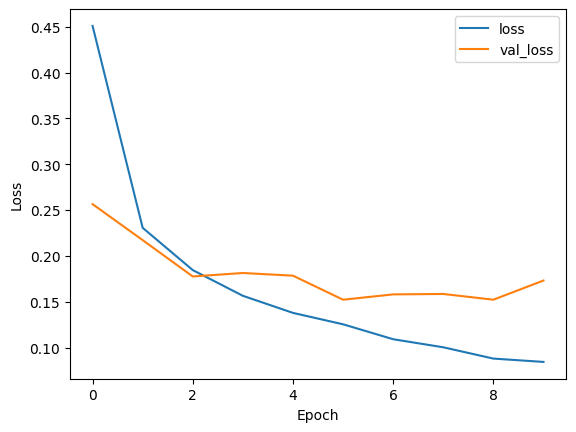

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.86,1])
plt.legend()
plt.show()

<a id="5"></a>
<h2 style="font-family: Verdana">5 <span style='color:#43B0C1; font-weight: bold;'>|</span> Testing</h2>  

In [20]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import load_model
classifier = load_model('model.hdf5')
image_path = input("Enter image path = ")
test_image = load_img(image_path,target_size = (128,128,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
result = classifier.predict(test_image)
print(result)
result = np.argmax(result)
result = class_names[result]

print("Predicted class = ",result)

Enter image path = /content/drive/MyDrive/kaggle/test/PNEUMONIA/person100_bacteria_475.jpeg
1/1 [==============================] - 0s 413ms/step
[[0. 0. 1. 0.]]
Predicted class =  PNEUMONIA
